In [1]:
!pip install -qU python-gdcm pydicom pylibjpeg

In [2]:
%pip install opencv-python opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import math
import numpy as np
import pandas as pd
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from tqdm.notebook import tqdm
import gc

import glob

#for dcm files
from joblib import Parallel, delayed
import pydicom

#for ROI model
import torch

In [5]:
ROI_model = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
ROI_model.conf = 0.25

Using cache found in /home/pushan/.cache/torch/hub/ultralytics_yolov5_master


requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)


YOLOv5 🚀 2024-11-19 Python-3.10.15 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


In [6]:
Config = {
    'output_dim_x' : 512,
    'output_dim_y' : 1024,
    'output_extension' : 'png',
    'skip_small_ROIs': True,
    'skip_unrecognized': True,
    'avoid_stretches': True
}

In [7]:
train_images_folder = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train'

In [8]:
%matplotlib inline

In [9]:
def show_image(img):
    if img is None:
        print("Failed to load image.")
        return
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap='cividis')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

def show_image_and_ROI(img,ROI):
    fig=plt.figure(figsize=(5, 5))

    rect = cv2.rectangle(img, (int(ROI['xmin']), int(ROI['ymin'])), (int(ROI['xmax']), int(ROI['ymax'])), (255,0,0), 4)

    plt.imshow(rect, cmap='cividis')

    plt.show()


def read_jpg_img(images_folder, disease, image_id):
    img_path = os.path.join(images_folder, f'{disease}.{image_id}.jpg')
    print(f"Loading image from: {img_path}")  # Debug print for path verification
    img = cv2.imread(img_path)

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    else:
        print("Image not found or unable to load.")

    return img

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/cocci/cocci.3.jpg


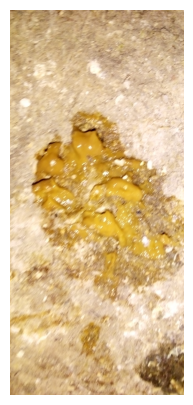

In [12]:
imf = '/home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/cocci'
dis = 'cocci'
img_id = '3'
show_image(read_jpg_img(imf, dis, img_id))

In [10]:
#ROI extraction function
#input: image
#output: (xmin,xmax,ymin,ymax)
def ROI_extraction(model, img,transform=None):
    if(transform):
        img = transform(img)

    #select only best prediction
    prediction = model(img).pandas().xyxy[0].to_dict(orient='records')

    if(len(prediction)==0):
        return None

    prediction = prediction[0]

    result = {key:prediction[key] for key in ['xmin','xmax','ymin','ymax']}

    if(transform):
        result = transform.inverse(result)

    return result

In [13]:
roi = ROI_extraction(ROI_model, read_jpg_img(imf, dis, img_id))
roi

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/cocci/cocci.3.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


{'xmin': 172.75784301757812,
 'xmax': 1357.560791015625,
 'ymin': 891.7886352539062,
 'ymax': 2069.7373046875}

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/cocci/cocci.3.jpg


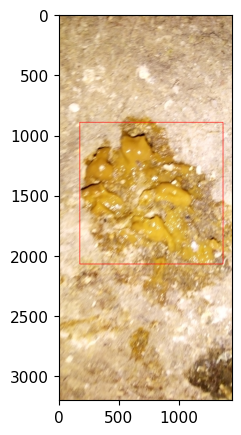

In [14]:
show_image_and_ROI(read_jpg_img(imf, dis, img_id),roi)

In [11]:
import cv2

def check_and_store_image(image_path, output_image_path, roi):
    """
    Check if the image is valid and if the ROI is correctly defined, then crop and save the image or save the original.
    
    Parameters:
    - image_path (str): Path to the image to be loaded.
    - output_image_path (str): Path to save the cropped image.
    - roi (dict): Dictionary containing 'xmin', 'xmax', 'ymin', 'ymax' for the ROI.
    """
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if the image is loaded correctly
    if image is None:
        #print(f"Error loading image: {image_path}")
        return
    
    # Check if roi is valid
    if roi and all(k in roi for k in ['xmin', 'xmax', 'ymin', 'ymax']):
        x1, y1, x2, y2 = int(roi['xmin']), int(roi['ymin']), int(roi['xmax']), int(roi['ymax'])
        
        # Ensure coordinates are within valid bounds
        height, width, _ = image.shape
        if 0 <= x1 < x2 <= width and 0 <= y1 < y2 <= height:
            # Crop the image and save
            cropped_image = image[y1:y2, x1:x2]
            cv2.imwrite(output_image_path, cropped_image)
            #print(f"Cropped image saved to: {output_image_path}")
            return
    
    # Save the original image if ROI is invalid or not provided
    cv2.imwrite(output_image_path, image)
    #print(f"Original image saved to: {output_image_path}")

In [12]:
import re

def process_images(images_folder, ROI_model, ROI_extraction, read_jpg_img, output_folder):
    # Initialize the output folder
    os.makedirs(output_folder, exist_ok=True)

    roi_list = []

    for disease in os.listdir(images_folder):
        # Define the paths for the disease folder
        disease_folder = os.path.join(images_folder, disease)
        output_disease_folder = os.path.join(output_folder, disease)

        # Create a directory for the disease in the output folder
        os.makedirs(output_disease_folder, exist_ok=True)

        images = os.listdir(disease_folder)

        for image_file in tqdm(images):
            image_path = os.path.join(disease_folder, image_file)
            output_image_path = os.path.join(output_disease_folder, image_file)

            # Extract the number from the image file name (e.g., <disease>.<num>.jpg)
            match = re.match(rf"{disease}\.(\d+)\.jpg", image_file)
            if match:
                num = int(match.group(1))  # Extracted number from filename
            else:
                continue  # If no match, skip this file

            # Read the image and extract the ROI
            roi = ROI_extraction(ROI_model, read_jpg_img(disease_folder, disease, num))

            # Check if image was loaded correctly
            check_and_store_image(image_path, output_image_path, roi)

            # Optionally append to roi_list if needed
            roi_list.append({
                'image_path': image_path,
                'roi': roi
            })

    return roi_list

In [17]:
train_images_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train"

output_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/train"
roi_list = process_images(train_images_folder, ROI_model, ROI_extraction, read_jpg_img, output_folder)

  0%|          | 0/449 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.0.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.1.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.2.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.3.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.4.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.5.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.6.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.7.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.8.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.9.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.10.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.11.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.12.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.13.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.14.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.15.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.16.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.17.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.18.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.19.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.20.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.21.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.22.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.23.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.24.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.25.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.26.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.27.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.28.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.29.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.30.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.31.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.32.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.33.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.34.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.35.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.36.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.37.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.38.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.39.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.40.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.41.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.42.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.43.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.44.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.45.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.46.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.47.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.48.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.49.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.50.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.51.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.52.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.53.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.54.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.55.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.56.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.57.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.58.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.59.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.60.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.61.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.62.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.63.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.64.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.65.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.66.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.67.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.68.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.69.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.70.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.71.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.72.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.73.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.74.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.75.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.76.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.77.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.78.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.79.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.80.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.81.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.82.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.83.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.84.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.85.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.86.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.87.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.88.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.89.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.90.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.91.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.92.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.93.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.94.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.95.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.96.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.97.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.98.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.99.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.100.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.101.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.103.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.104.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.105.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.109.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.111.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.113.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.115.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.116.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.117.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.119.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.121.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.123.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.124.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.126.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.128.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.130.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.132.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.134.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.135.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.136.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.138.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.140.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.142.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.144.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.145.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.146.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.147.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.148.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.150.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.152.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.154.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.156.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.158.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.159.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.162.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.165.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.167.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.169.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.171.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.173.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.175.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.177.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.179.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.181.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.183.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.185.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.188.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.190.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.192.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.194.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.199.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.202.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.205.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.207.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.209.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.211.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.213.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.214.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.215.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.217.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.219.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.220.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.221.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.222.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.223.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.224.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.225.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.226.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.228.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.230.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.232.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.233.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.239.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.246.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.248.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.250.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.252.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.254.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.256.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.258.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.260.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.262.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.264.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.266.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.270.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.273.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.274.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.277.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.278.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.285.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.287.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.289.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.291.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.293.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.294.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.295.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.297.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.299.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.300.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.301.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.303.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.305.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.321.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.323.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.325.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.327.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.329.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.331.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.332.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.333.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.334.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.336.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.338.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.340.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.342.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.344.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.346.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.348.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.349.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.350.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.352.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.357.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.359.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.361.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.363.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.367.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.369.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.371.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.372.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.373.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.374.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.376.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.378.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.379.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.380.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.382.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.384.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.386.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.388.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.390.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.391.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.392.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.393.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.395.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.397.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.399.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.401.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.403.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.404.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.405.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.406.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.407.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.408.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.409.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.410.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.411.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.412.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.413.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.414.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.415.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.416.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.417.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.418.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.419.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.420.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.421.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.422.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.423.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.424.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.425.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.426.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.427.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.428.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.429.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.430.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.431.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.432.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.433.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.434.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.435.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.436.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.437.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.438.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.439.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.440.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.441.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.442.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.443.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.444.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.445.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.446.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.447.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/ncd/ncd.448.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/2100 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.0.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.3.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.4.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.5.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.6.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.7.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.8.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.9.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.10.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.11.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.12.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.13.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.14.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.15.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.16.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.17.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.18.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.19.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.20.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.21.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.22.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.23.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.24.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.25.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.26.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.27.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.28.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.29.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.30.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.31.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.32.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.33.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.34.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.35.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.36.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.37.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.38.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.39.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.40.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.41.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.42.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.43.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.44.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.45.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.46.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.47.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.48.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.49.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.50.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.51.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.52.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.53.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.54.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.55.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.56.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.57.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.58.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.59.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.60.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.61.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.62.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.63.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.64.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.65.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.66.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.67.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.68.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.69.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.70.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.71.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.72.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.73.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.74.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.75.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.76.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.77.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.78.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.79.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.80.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.81.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.82.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.83.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.84.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.85.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.86.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.87.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.88.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.89.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.90.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.91.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.92.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.93.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.94.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.95.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.96.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.97.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.98.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.99.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.100.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.101.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.103.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.104.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.105.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.109.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.111.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.113.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.115.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.116.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.117.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.119.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.121.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.123.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.124.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.126.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.128.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.130.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.132.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.134.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.135.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.136.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.138.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.140.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.142.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.144.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.145.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.146.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.147.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.148.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.150.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.152.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.154.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.156.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.158.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.159.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.162.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.165.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.167.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.169.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.171.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.173.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.175.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.177.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.179.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.181.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.183.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.185.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.188.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.190.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.192.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.194.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.199.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.202.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.205.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.207.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.209.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.211.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.213.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.214.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.215.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.217.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.219.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.220.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.221.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.222.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.223.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.224.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.225.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.226.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.228.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.230.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.232.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.233.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.239.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.246.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.248.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.250.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.252.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.254.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.256.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.258.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.260.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.262.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.264.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.266.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.270.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.273.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.274.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.277.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.278.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.285.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.287.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.289.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.291.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.293.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.294.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.295.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.297.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.299.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.300.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.301.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.303.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.305.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.321.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.323.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.325.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.327.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.329.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.331.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.332.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.333.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.334.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.336.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.338.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.340.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.342.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.344.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.346.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.348.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.349.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.350.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.352.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.357.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.359.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.361.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.363.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.367.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.369.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.371.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.372.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.373.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.374.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.376.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.378.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.379.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.380.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.382.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.384.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.386.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.388.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.390.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.391.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.392.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.393.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.395.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.397.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.399.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.401.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.403.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.404.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.405.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.406.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.407.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.408.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.409.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.410.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.411.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.412.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.413.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.414.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.415.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.416.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.417.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.418.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.419.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.420.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.421.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.422.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.423.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.424.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.425.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.426.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.427.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.428.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.429.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.430.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.431.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.432.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.433.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.434.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.435.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.436.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.437.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.438.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.439.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.440.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.441.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.442.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.443.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.444.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.445.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.446.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.447.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.448.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.449.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.450.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.451.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.452.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.453.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.454.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.455.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.456.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.457.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.458.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.459.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.460.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.461.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.462.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.463.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.464.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.465.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.466.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.467.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.468.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.469.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.470.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.471.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.472.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.473.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.474.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.475.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.476.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.477.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.478.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.479.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.480.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.481.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.482.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.483.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.484.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.485.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.486.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.487.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.488.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.489.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.490.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.491.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.492.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.493.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.494.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.495.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.496.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.497.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.498.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.499.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.500.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.501.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.502.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.503.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.504.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.505.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.506.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.507.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.508.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.509.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.510.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.511.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.512.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.513.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.514.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.515.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.516.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.517.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.518.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.519.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.520.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.521.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.522.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.523.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.524.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.525.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.526.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.527.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.528.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.529.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.530.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.531.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.532.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.533.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.534.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.535.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.536.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.537.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.538.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.539.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.540.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.541.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.542.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.543.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.544.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.545.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.546.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.547.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.548.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.549.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.550.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.551.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.552.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.553.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.554.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.555.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.556.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.557.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.558.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.559.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.560.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.561.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.562.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.563.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.564.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.565.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.566.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.567.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.568.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.569.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.570.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.571.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.572.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.573.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.574.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.575.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.576.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.577.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.578.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.579.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.580.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.581.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.582.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.583.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.584.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.585.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.586.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.587.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.588.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.589.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.590.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.591.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.592.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.593.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.594.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.595.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.596.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.597.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.598.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.599.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.600.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.601.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.602.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.603.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.604.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.605.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.606.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.607.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.608.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.609.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.610.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.611.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.612.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.613.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.614.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.615.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.616.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.617.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.618.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.619.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.620.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.621.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.622.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.623.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.624.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.625.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.626.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.627.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.628.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.629.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.630.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.631.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.632.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.633.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.634.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.635.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.636.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.637.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.638.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.639.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.640.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.641.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.642.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.643.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.644.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.645.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.646.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.647.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.648.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.649.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.650.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.651.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.652.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.653.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.654.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.655.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.656.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.657.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.658.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.659.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.660.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.661.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.662.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.663.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.664.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.665.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.666.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.667.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.668.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.669.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.670.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.671.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.672.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.673.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.674.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.675.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.676.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.677.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.678.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.679.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.680.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.681.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.682.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.683.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.684.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.685.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.686.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.687.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.688.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.689.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.690.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.691.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.692.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.693.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.694.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.695.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.696.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.697.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.698.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.699.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.700.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.701.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.702.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.703.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.704.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.705.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.706.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.707.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.708.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.709.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.710.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.711.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.712.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.713.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.714.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.715.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.716.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.717.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.718.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.719.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.720.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.721.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.722.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.723.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.724.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.725.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.726.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.727.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.728.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.729.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.730.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.731.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.732.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.733.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.734.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.735.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.736.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.737.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.738.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.739.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.740.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.741.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.742.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.743.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.744.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.745.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.746.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.747.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.748.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.749.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.750.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.751.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.752.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.753.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.754.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.755.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.756.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.757.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.758.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.759.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.760.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.761.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.762.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.763.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.764.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.765.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.766.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.767.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.768.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.769.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.770.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.771.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.772.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.773.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.774.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.775.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.776.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.777.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.778.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.779.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.780.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.781.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.782.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.783.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.784.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.785.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.786.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.787.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.788.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.789.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.790.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.791.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.792.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.793.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.794.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.795.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.796.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.797.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.798.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.799.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.800.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.801.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.802.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.803.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.804.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.805.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.806.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.807.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.808.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.809.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.810.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.811.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.812.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.813.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.814.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.815.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.816.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.817.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.818.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.819.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.820.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.821.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.822.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.823.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.824.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.825.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.826.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.827.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.828.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.829.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.830.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.831.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.832.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.833.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.834.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.835.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.836.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.837.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.838.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.839.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.840.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.841.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.842.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.843.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.844.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.845.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.846.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.847.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.848.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.849.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.850.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.851.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.852.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.853.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.854.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.855.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.856.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.857.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.858.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.859.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.860.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.861.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.862.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.863.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.864.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.865.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.866.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.867.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.868.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.869.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.870.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.871.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.872.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.873.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.874.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.875.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.876.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.877.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.878.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.879.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.880.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.881.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.882.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.883.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.884.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.885.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.886.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.887.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.888.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.889.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.890.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.891.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.892.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.893.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.894.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.895.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.896.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.897.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.898.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.899.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.900.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.901.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.902.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.903.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.904.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.905.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.906.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.907.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.908.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.909.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.910.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.911.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.912.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.913.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.914.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.915.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.916.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.917.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.918.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.919.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.920.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.921.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.922.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.923.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.924.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.925.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.926.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.927.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.928.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.929.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.930.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.931.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.932.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.933.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.934.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.935.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.936.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.937.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.938.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.939.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.940.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.941.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.942.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.943.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.944.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.945.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.946.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.947.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.948.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.949.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.950.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.951.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.952.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.953.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.954.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.955.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.956.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.957.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.958.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.959.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.960.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.961.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.962.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.963.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.964.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.965.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.966.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.967.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.968.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.969.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.970.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.971.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.972.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.973.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.974.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.975.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.976.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.977.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.978.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.979.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.980.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.981.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.982.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.983.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.984.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.985.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.986.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.987.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.988.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.989.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.990.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.991.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.992.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.993.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.994.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.995.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.996.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.997.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.998.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.999.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1000.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1001.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1002.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1003.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1004.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1005.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1006.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1007.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1008.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1009.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1010.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1011.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1012.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1013.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1014.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1015.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1016.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1017.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1018.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1019.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1020.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1021.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1022.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1023.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1024.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1025.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1026.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1027.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1028.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1029.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1030.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1031.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1032.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1033.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1034.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1035.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1036.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1037.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1038.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1039.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1040.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1041.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1042.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1043.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1044.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1045.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1046.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1047.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1048.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1049.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1050.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1051.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1052.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1053.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1054.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1055.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1056.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1057.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1058.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1059.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1060.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1061.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1062.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1063.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1064.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1065.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1066.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1067.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1068.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1069.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1070.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1071.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1072.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1073.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1074.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1075.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1076.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1077.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1078.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1079.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1080.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1081.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1082.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1083.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1084.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1085.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1086.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1087.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1088.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1089.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1090.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1091.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1092.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1093.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1094.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1095.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1096.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1097.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1098.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1099.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1100.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1101.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1103.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1104.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1105.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1109.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1111.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1113.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1115.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1116.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1117.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1119.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1121.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1123.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1124.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1126.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1128.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1130.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1132.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1134.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1135.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1136.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1138.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1140.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1142.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1144.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1145.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1146.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1147.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1148.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1150.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1152.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1154.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1156.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1158.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1159.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1162.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1165.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1167.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1169.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1171.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1173.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1175.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1177.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1179.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1181.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1183.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1185.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1188.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1190.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1192.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1194.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1199.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1202.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1205.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1207.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1209.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1211.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1213.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1214.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1215.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1217.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1219.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1220.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1221.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1222.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1223.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1224.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1225.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1226.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1228.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1230.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1232.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1233.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1239.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1246.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1248.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1250.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1252.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1254.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1256.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1258.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1260.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1262.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1264.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1266.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1270.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1273.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1274.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1277.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1278.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1285.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1287.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1289.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1291.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1293.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1294.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1295.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1297.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1299.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1300.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1301.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1303.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1305.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1321.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1323.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1325.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1327.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1329.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1331.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1332.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1333.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1334.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1336.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1338.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1340.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1342.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1344.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1346.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1348.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1349.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1350.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1352.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1357.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1359.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1361.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1363.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1367.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1369.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1371.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1372.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1373.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1374.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1376.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1378.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1379.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1380.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1382.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1384.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1386.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1388.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1390.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1391.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1392.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1393.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1395.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1397.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1399.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1401.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1403.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1404.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1405.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1406.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1407.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1408.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1409.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1410.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1411.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1412.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1413.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1414.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1415.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1416.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1417.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1418.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1419.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1420.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1421.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1422.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1423.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1424.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1425.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1426.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1427.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1428.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1429.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1430.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1431.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1432.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1433.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1434.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1435.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1436.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1437.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1438.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1439.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1440.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1441.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1442.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1443.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1444.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1445.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1446.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1447.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1448.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1449.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1450.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1451.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1452.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1453.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1454.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1455.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1456.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1457.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1458.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1459.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1460.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1461.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1462.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1463.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1464.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1465.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1466.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1467.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1468.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1469.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1470.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1471.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1472.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1473.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1474.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1475.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1476.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1477.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1478.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1479.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1480.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1481.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1482.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1483.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1484.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1485.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1486.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1487.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1488.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1489.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1490.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1491.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1492.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1493.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1494.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1495.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1496.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1497.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1498.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1499.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1500.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1501.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1502.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1503.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1504.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1505.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1506.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1507.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1508.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1509.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1510.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1511.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1512.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1513.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1514.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1515.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1516.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1517.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1518.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1519.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1520.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1521.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1522.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1523.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1524.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1525.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1526.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1527.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1528.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1529.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1530.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1531.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1532.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1533.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1534.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1535.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1536.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1537.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1538.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1539.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1540.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1541.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1542.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1543.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1544.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1545.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1546.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1547.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1548.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1549.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1550.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1551.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1552.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1553.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1554.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1555.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1556.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1557.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1558.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1559.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1560.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1561.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1562.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1563.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1564.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1565.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1566.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1567.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1568.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1569.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1570.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1571.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1572.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1573.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1574.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1575.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1576.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1577.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1578.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1579.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1580.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1581.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1582.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1583.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1584.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1585.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1586.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1587.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1588.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1589.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1590.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1591.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1592.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1593.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1594.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1595.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1596.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1597.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1598.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1599.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1600.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1601.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1602.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1603.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1604.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1605.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1606.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1607.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1608.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1609.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1610.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1611.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1612.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1613.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1614.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1615.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1616.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1617.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1618.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1619.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1620.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1621.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1622.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1623.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1624.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1625.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1626.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1627.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1628.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1629.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1630.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1631.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1632.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1633.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1634.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1635.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1636.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1637.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1638.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1639.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1640.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1641.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1642.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1643.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1644.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1645.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1646.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1647.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1648.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1649.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1650.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1651.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1652.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1653.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1654.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1655.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1656.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1657.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1658.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1659.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1660.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1661.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1662.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1663.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1664.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1665.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1666.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1667.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1668.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1669.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1670.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1671.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1672.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1673.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1674.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1675.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1676.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1677.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1678.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1679.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1680.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1681.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1682.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1683.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1684.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1685.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1686.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1687.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1688.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1689.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1690.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1691.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1692.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1693.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1694.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1695.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1696.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1697.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1698.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1699.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1700.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1701.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1702.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1703.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1704.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1705.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1706.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1707.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1708.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1709.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1710.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1711.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1712.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1713.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1714.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1715.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1716.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1717.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1718.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1719.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1720.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1721.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1722.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1723.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1724.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1725.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1726.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1727.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1728.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1729.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1730.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1731.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1732.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1733.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1734.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1735.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1736.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1737.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1738.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1739.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1740.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1741.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1742.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1743.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1744.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1745.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1746.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1747.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1748.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1749.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1750.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1751.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1752.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1753.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1754.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1755.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1756.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1757.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1758.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1759.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1760.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1761.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1762.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1763.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1764.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1765.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1766.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1767.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1768.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1769.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1770.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1771.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1772.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1773.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1774.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1775.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1776.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1777.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1778.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1779.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1780.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1781.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1782.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1783.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1784.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1785.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1786.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1787.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1788.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1789.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1790.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1791.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1792.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1793.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1794.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1795.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1796.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1797.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1798.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1799.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1800.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1801.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1802.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1803.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1804.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1805.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1806.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1807.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1808.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1809.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1810.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1811.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1812.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1813.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1814.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1815.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1816.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1817.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1818.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1819.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1820.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1821.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1822.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1823.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1824.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1825.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1826.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1827.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1828.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1829.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1830.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1831.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1832.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1833.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1834.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1835.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1836.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1837.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1838.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1839.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1840.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1841.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1842.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1843.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1844.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1845.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1846.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1847.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1848.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1849.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1850.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1851.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1852.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1853.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1854.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1855.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1856.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1857.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1858.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1859.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1860.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1861.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1862.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1863.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1864.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1865.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1866.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1867.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1868.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1869.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1870.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1871.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1872.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1873.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1874.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1875.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1876.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1877.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1878.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1879.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1880.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1881.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1882.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1883.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1884.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1885.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1886.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1887.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1888.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1889.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1890.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1891.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1892.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1893.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1894.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1895.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1896.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1897.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1898.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1899.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1900.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1901.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1902.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1903.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1904.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1905.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1906.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1907.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1908.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1909.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1910.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1911.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1912.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1913.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1914.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1915.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1916.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1917.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1918.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1919.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1920.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1921.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1922.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1923.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1924.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1925.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1926.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1927.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1928.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1929.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1930.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1931.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1932.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1933.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1934.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1935.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1936.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1937.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1938.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1939.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1940.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1941.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1942.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1943.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1944.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1945.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1946.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1947.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1948.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1949.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1950.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1951.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1952.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1953.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1954.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1955.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1956.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1957.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1958.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1959.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1960.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1961.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1962.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1963.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1964.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1965.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1966.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1967.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1968.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1969.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1970.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1971.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1972.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1973.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1974.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1975.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1976.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1977.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1978.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1979.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1980.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1981.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1982.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1983.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1984.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1985.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1986.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1987.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1988.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1989.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1990.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1991.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1992.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1993.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1994.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1995.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1996.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1997.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1998.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.1999.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2000.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2001.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2002.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2003.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2004.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2005.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2006.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2007.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2008.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2009.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2010.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2011.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2012.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2013.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2014.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2015.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2016.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2017.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2018.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2019.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2020.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2021.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2022.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2023.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2024.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2025.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2026.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2027.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2028.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2029.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2030.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2031.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2032.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2033.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2034.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2035.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2036.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2037.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2038.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2039.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2040.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2041.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2042.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2043.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2044.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2045.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2046.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2047.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2048.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2049.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2050.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2051.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2052.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2053.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2054.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2055.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2056.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2057.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2058.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2059.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2060.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2061.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2062.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2063.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2064.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2065.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2066.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2067.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2068.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2069.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2070.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2071.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2072.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2073.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2074.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2075.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2076.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2077.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2078.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2079.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2080.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2081.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2082.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2083.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2084.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2085.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2086.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2087.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2088.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2089.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2090.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2091.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2092.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2093.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2094.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2095.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2096.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2097.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2098.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/train/salmo/salmo.2099.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [19]:
val_images_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val"

val_output_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/val"
roi_list = process_images(val_images_folder, ROI_model, ROI_extraction, read_jpg_img, val_output_folder)

  0%|          | 0/248 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2409.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2397.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2361.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2472.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2433.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2228.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2239.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2464.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2256.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2384.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2258.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2349.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2338.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2403.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2432.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2233.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2293.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2458.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2414.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2404.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2407.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2408.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2434.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2274.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2413.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2372.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2270.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2248.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2299.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2468.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2273.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2262.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2334.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2392.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2371.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2287.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2336.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2352.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2446.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2323.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2419.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2415.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2452.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2348.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2373.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2411.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2395.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2435.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2401.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2230.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2350.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2426.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2416.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2301.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2285.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2420.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2386.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2418.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2252.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2329.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2460.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2469.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2431.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2459.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2390.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2445.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2332.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2427.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2399.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2439.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2277.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2246.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2327.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2447.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2278.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2423.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2232.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2374.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2467.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2471.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2428.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2325.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2297.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2393.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2430.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2406.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2451.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2254.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2388.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2294.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2470.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2300.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2440.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2429.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2442.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2266.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2340.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2453.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2357.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2457.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2465.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2331.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2291.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2367.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2449.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2436.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2421.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2454.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2305.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2441.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2438.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2342.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2363.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2369.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2461.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2424.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2380.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2410.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2412.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2437.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2448.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2321.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2376.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2425.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2303.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2474.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2422.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2382.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2466.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2456.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2359.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2444.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2473.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2295.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2379.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2417.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2443.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2346.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2344.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2455.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2475.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2391.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2405.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2462.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2463.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2378.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2450.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2264.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2289.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2260.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2250.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/cocci/cocci.2333.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/241 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2126.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1969.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2015.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1958.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2055.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2073.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2007.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2128.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2051.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1959.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2061.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2059.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1962.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2094.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2159.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1950.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1989.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2105.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2156.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1992.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1977.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2060.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1981.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2070.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2124.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2003.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1951.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1994.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1947.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1961.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2066.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1982.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1979.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2038.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2146.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1931.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2085.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1966.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2072.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1929.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2135.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1938.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2098.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2013.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2093.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1942.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2140.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1933.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2154.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1936.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2087.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2048.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2024.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2034.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1946.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1926.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2019.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2074.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2028.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2047.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1948.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2121.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2119.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2058.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2033.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2027.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2035.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1945.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1939.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1973.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2123.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1940.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2045.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2030.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2117.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1960.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2063.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1964.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2037.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1928.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2014.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2144.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1943.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2010.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2136.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1984.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2083.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1988.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1944.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2021.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2005.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2148.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1927.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1952.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2064.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2039.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1924.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2006.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1968.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2111.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2081.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2000.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1923.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2104.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1930.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1998.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2022.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1941.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2138.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1934.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2132.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2044.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1965.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1987.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2001.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1963.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2091.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2068.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2152.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2011.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2084.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2042.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2040.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1991.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2101.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1985.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2057.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2002.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2162.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1993.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2100.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2067.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2071.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2147.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2116.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2017.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2012.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2113.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2142.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2036.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2008.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2065.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2004.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2158.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2026.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1925.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2082.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1996.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2032.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1997.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2109.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2096.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2095.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1953.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2054.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2103.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2025.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1954.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2115.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1976.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1957.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2050.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2075.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1975.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1972.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1986.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2080.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2145.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1999.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2099.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2086.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2088.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1990.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2056.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2069.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2079.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1949.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2031.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2076.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2053.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2020.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1932.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1980.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2130.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2090.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2092.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2023.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1955.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2078.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2018.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1983.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2089.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1956.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2016.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1971.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2097.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1974.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2052.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1995.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2077.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1970.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2134.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2041.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2029.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1978.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1935.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2043.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2150.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1967.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2049.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2062.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2009.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.2046.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/healthy/healthy.1937.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/55 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.475.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.481.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.488.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.473.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.471.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.494.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.468.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.493.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.492.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.477.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.496.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.459.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.503.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.476.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.456.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.501.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.483.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.470.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.452.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.466.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.457.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.479.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.465.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.464.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.474.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.455.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.486.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.500.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.491.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.502.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.495.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.478.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.462.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.487.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.480.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.460.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.458.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.453.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.498.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.467.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.454.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.463.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.485.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.472.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.469.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.489.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.499.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.450.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.484.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.482.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.461.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.497.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.490.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.449.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/ncd/ncd.451.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/262 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2277.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2331.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2274.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2230.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2217.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2250.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2346.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2207.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2300.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2344.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2336.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2154.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2301.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2273.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2295.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2297.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2175.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2135.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2150.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2192.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2134.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2287.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2148.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2156.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2264.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2352.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2211.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2165.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2256.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2181.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2225.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2350.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2117.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2303.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2144.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2361.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2226.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2323.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2270.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2140.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2113.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2111.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2173.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2128.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2252.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2104.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2239.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2101.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2177.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2340.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2291.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2224.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2215.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2147.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2167.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2334.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2359.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2130.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2119.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2232.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2305.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2109.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2214.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2142.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2342.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2188.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2202.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2171.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2327.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2254.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2179.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2233.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2190.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2248.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2126.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2332.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2115.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2289.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2194.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2116.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2278.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2185.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2221.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2183.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2121.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2338.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2124.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2132.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2348.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2103.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2152.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2228.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2123.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2258.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2262.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2260.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2349.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2357.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2219.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2246.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2293.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2205.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2213.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2333.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2169.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2145.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2138.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2209.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2220.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2285.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2329.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2266.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2223.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2222.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2100.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2158.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2146.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2299.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2105.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2162.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2321.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2199.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2294.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2325.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2136.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/val/salmo/salmo.2159.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [13]:
test_images_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test"

test_output_folder = "/home/pushan/Desktop/ML/ML_PROJECT/4628934/roi_extracted/test"
roi_list = process_images(test_images_folder, ROI_model, ROI_extraction, read_jpg_img, test_output_folder)

  0%|          | 0/248 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2010.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2139.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2138.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2033.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2169.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2131.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2150.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2219.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2093.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2152.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2205.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2167.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2071.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1985.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2084.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2067.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2130.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2078.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2111.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2088.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2046.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1997.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2017.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2171.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1980.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2003.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2181.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2143.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1986.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2074.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2199.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2147.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2059.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2104.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2054.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2064.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1983.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2040.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2121.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2001.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2224.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2153.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2089.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2117.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2132.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2035.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2105.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2214.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2106.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1992.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2022.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2063.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2005.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2135.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2050.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2134.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2173.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2175.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2076.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2065.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2094.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2056.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2179.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2085.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2144.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2018.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2066.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2112.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2029.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2215.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2222.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2092.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2118.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2129.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2220.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2098.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2157.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2039.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2217.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2124.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2086.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2052.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2107.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2041.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2079.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2116.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2109.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2177.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1989.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2099.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2016.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2165.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2142.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2034.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2192.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2037.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2159.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2031.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2019.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1981.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1990.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2011.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2070.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1987.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2083.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2043.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2158.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2015.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2024.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2025.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2049.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2137.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2100.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2038.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1994.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2036.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2145.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2225.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2190.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2062.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2023.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1995.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2021.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2030.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2028.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2013.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2211.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1984.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2097.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2128.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2027.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2125.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2087.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1988.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2026.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2090.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2061.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2102.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2113.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2213.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1993.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2012.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2082.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2077.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2060.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2221.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2047.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2133.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2006.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2020.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2096.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2149.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2160.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2032.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1991.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2122.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2127.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2095.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2081.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2148.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1998.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2103.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2207.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2202.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2154.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2223.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2110.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2146.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2209.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2069.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2188.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2091.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2002.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2051.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2119.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2140.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2101.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2072.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2053.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2183.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2042.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2155.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2226.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2141.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2114.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2009.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2151.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2000.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2075.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2185.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2055.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2162.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2126.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2008.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2058.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2156.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2044.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1982.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2163.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2057.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1999.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2120.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2108.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2014.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2115.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2068.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.1996.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2073.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2048.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2004.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2136.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2194.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2123.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2080.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2007.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2045.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/cocci/cocci.2161.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/240 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2297.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2348.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2252.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2202.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2189.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2257.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2304.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2213.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2359.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2291.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2250.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2192.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2367.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2199.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2379.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2358.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2333.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2224.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2376.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2255.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2217.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2352.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2393.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2229.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2355.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2326.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2350.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2285.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2264.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2209.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2316.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2178.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2323.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2312.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2386.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2306.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2173.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2223.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2206.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2289.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2310.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2371.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2369.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2334.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2363.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2337.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2354.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2275.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2269.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2286.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2205.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2329.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2283.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2324.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2278.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2195.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2238.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2266.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2203.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2259.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2339.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2403.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2261.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2200.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2282.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2241.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2196.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2347.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2373.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2245.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2311.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2177.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2214.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2317.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2391.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2319.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2262.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2256.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2225.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2207.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2309.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2277.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2313.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2342.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2276.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2287.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2183.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2265.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2280.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2216.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2307.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2332.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2247.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2372.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2242.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2378.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2338.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2346.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2169.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2165.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2302.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2168.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2284.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2303.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2186.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2246.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2268.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2341.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2260.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2279.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2296.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2301.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2194.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2336.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2327.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2258.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2210.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2349.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2298.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2228.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2227.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2219.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2170.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2314.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2218.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2356.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2236.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2331.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2235.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2300.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2272.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2399.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2190.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2187.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2179.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2288.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2176.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2267.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2164.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2344.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2380.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2315.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2345.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2390.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2308.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2290.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2215.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2335.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2188.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2388.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2351.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2353.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2361.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2239.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2240.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2211.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2174.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2328.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2281.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2184.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2208.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2292.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2384.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2322.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2243.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2185.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2248.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2233.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2340.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2197.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2330.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2321.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2293.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2273.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2374.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2263.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2166.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2201.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2397.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2320.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2395.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2305.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2231.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2182.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2232.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2175.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2167.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2357.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2299.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2222.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2212.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2270.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2295.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2254.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2193.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2198.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2204.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2171.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2271.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2181.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2274.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2325.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2249.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2251.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2343.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2220.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2180.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2392.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2191.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2244.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2382.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2172.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2237.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2226.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2318.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2234.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2294.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2401.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2221.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2230.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2360.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/healthy/healthy.2253.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/58 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.523.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.558.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.517.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.540.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.515.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.529.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.547.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.526.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.538.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.537.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.549.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.524.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.508.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.518.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.531.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.551.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.516.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.520.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.528.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.535.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.509.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.555.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.532.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.556.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.525.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.544.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.504.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.559.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.534.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.506.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.533.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.542.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.552.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.511.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.510.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.560.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.553.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.543.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.550.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.545.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.514.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.554.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.521.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.530.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.561.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.536.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.507.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.505.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.527.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.522.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.548.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.546.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.541.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.512.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.557.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.519.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.513.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/ncd/ncd.539.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


  0%|          | 0/263 [00:00<?, ?it/s]

Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2425.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2613.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2423.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2590.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2365.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2592.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2469.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2477.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2480.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2371.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2508.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2498.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2439.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2549.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2538.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2367.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2589.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2399.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2586.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2429.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2603.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2451.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2370.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2523.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2610.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2382.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2579.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2527.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2395.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2418.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2499.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2393.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2568.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2471.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2569.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2500.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2587.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2570.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2362.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2363.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2490.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2503.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2604.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2461.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2437.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2612.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2467.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2464.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2619.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2433.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2575.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2379.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2553.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2618.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2607.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2416.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2548.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2581.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2369.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2487.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2478.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2446.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2383.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2494.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2485.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2384.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2622.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2552.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2542.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2582.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2419.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2585.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2620.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2374.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2600.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2435.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2434.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2453.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2517.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2431.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2501.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2562.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2623.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2578.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2389.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2420.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2563.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2601.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2442.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2574.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2524.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2606.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2385.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2583.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2502.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2404.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2409.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2402.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2455.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2545.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2468.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2366.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2557.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2377.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2372.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2555.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2454.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2448.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2522.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2495.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2532.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2427.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2394.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2481.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2411.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2576.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2412.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2388.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2529.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2615.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2368.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2565.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2421.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2528.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2602.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2422.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2401.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2611.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2488.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2489.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2386.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2564.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2546.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2438.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2504.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2571.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2513.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2624.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2597.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2479.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2492.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2465.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2380.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2525.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2605.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2428.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2543.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2456.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2392.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2443.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2507.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2521.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2588.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2474.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2403.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2441.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2452.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2413.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2544.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2376.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2486.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2520.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2445.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2470.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2584.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2484.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2518.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2580.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2609.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2497.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2608.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2535.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2540.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2594.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2457.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2534.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2430.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2364.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2593.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2444.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2459.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2596.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2400.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2510.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2599.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2460.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2373.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2595.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2572.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2476.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2483.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2511.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2506.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2496.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2436.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2462.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2536.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2450.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2512.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2614.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2514.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2559.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2556.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2407.jpg
Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2415.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2526.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2491.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2417.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2537.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2426.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2387.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2391.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2449.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2424.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2432.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2551.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2617.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2550.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2566.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2516.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2440.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2561.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2616.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2541.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2482.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2591.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2515.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2473.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2530.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2493.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2558.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2621.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2567.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2398.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2560.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2458.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2475.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2406.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2577.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2447.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2573.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2408.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2598.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2390.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2375.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2472.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2531.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2463.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2405.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2396.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2547.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2410.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2539.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2381.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2509.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2519.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2397.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2378.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2533.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2414.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2554.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2505.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Loading image from: /home/pushan/Desktop/ML/ML_PROJECT/4628934/original_dataset/test/salmo/salmo.2466.jpg


/home/pushan/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
